# Data Drift Detector

Data Drift Detector provides some quick methods to detect data drift. This may be commonly needed to identify if a live machine learning model's performance have dipped due to data drift in the production environment. These methods include calculating the distribution distances, plotting of graphs, and comparing the ML efficacy of the 2 datasets.

This notebook will demonstrate the usage of the data drift detector package.

In [123]:
import numpy as np
import pandas as pd
import copy
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import CatBoostEncoder
from scipy.spatial.distance import jensenshannon
from scipy.stats import gaussian_kde
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (r2_score, mean_absolute_error, precision_score,
                             recall_score, accuracy_score, f1_score,
                             roc_auc_score)
from sklearn.utils import shuffle

import logging
logger = logging.getLogger(__name__)


class DataDriftDetector:
    """Compare differences between 2 datasets

    DataDriftDetector creates useful methods to compare 2 datasets,
    created to allow ease of measuring the fidelity between 2 datasets.

    Methods
    ----
    calculate_drift:
        Calculates the distribution distance for each column between the
        datasets with the jensen shannon metric

    plot_numeric_to_numeric:
        Creates a pairplot between the 2 datasets

    plot_categorical_to_numeric:
        Creates a pairgrid violin plot between the 2 datasets

    compare_ml_efficacy:
        Compares the ML efficacy of a model built between the 2 datasets

    Args
    ----
    df_prior: <pandas.DataFrame>
        Pandas dataframe of the prior dataset. In practice, this would be the
        dataset used to train a live model

    df_post: <pandas.DataFrame>
        Pandas dataframe of the post dataset. In practice, this would be the
        current dataset that's flowing into a live model

    categorical_columns: <list of str>
        A list of categorical columns in the dataset, will be determined by
        column types if not provided

    numeric_columns: <list of str>
        A list of numerical columns in the dataset, will be determined by
        column types if not provided

    """
    def __init__(self,
                 df_prior,
                 df_post,
                 categorical_columns=None,
                 numeric_columns=None):

        df_prior_ = copy.deepcopy(df_prior)
        df_post_ = copy.deepcopy(df_post)

        if categorical_columns is None:
            categorical_columns = [i for i in df_prior_.columns if
                                df_prior_.dtypes[i]=='object']

        logger.info("Categorical column(s): ", categorical_columns)

        df_prior_[categorical_columns] = df_prior_[categorical_columns].astype(str)
        df_post_[categorical_columns] = df_post_[categorical_columns].astype(str)

        if numeric_columns is None:
            numeric_columns = [i for i in df_prior_.columns if
                            df_prior_.dtypes[i] in ['float64','float32',
                                                    'int32','int64','uint8']]

        logger.info("\nNumerical column(s): ", numeric_columns)

        df_prior_[numeric_columns] = df_prior_[numeric_columns].astype(float)
        df_post_[numeric_columns] = df_post_[numeric_columns].astype(float)

        self.categorical_columns = categorical_columns
        self.numeric_columns = numeric_columns

        self.df_prior = df_prior_
        self.df_post = df_post_


    def calculate_drift(self):
        """Calculates the jensen shannon distance between the 2 datasets

        For categorical columns, the probability of each category will be
        computed separately for `df_prior` and `df_post`, and the jensen
        shannon distance between the 2 probability arrays will be computed. For
        numerical columns, the values will first be fitted into a gaussian KDE
        separately for `df_prior` and `df_post`, and a probability array
        will be sampled from them and compared with the jensen shannon distance

        Returns
        ----
        Sorted list of tuples containing the column name followed by the 
        computed jensen shannon distance
        """
        res = {}
        STEPS = 100

        for col in self.categorical_columns:
            # to ensure similar order, concat before computing probability
            col_prior = self.df_prior[col].to_frame()
            col_post = self.df_post[col].to_frame()
            col_prior['source'] = 'prior'
            col_post['source'] = 'post'

            col_ = pd.concat([col_prior, col_post], ignore_index=True)
            
            # aggregate and convert to probability array
            arr = (col_.groupby(['CHAS', 'source'])
                       .size()
                       .to_frame()
                       .reset_index()
                       .pivot(index='CHAS', columns='source')
                       .droplevel(0, axis=1)
                  )
            arr_ = arr.div(arr.sum(axis=0),axis=1)
            
            # calculate distance
            d = jensenshannon(arr_['prior'].to_numpy(),
                              arr_['post'].to_numpy())

            res.update({col: d})

        for col in self.numeric_columns:
            # fit gaussian_kde
            col_prior = self.df_prior[col]
            col_post = self.df_post[col]
            kde_prior = gaussian_kde(col_prior)
            kde_post = gaussian_kde(col_post)

            # get range of values
            min_ = min(col_prior.min(), col_post.min())
            max_ = max(col_prior.max(), col_post.max())
            range = np.linspace(start=min_, stop=max_, num=STEPS)

            # sample range from KDE
            arr_prior_ = kde_prior(range)
            arr_post_ = kde_post(range)
            
            arr_prior = arr_prior_ / np.sum(arr_prior_)
            arr_post = arr_post_ / np.sum(arr_post_)

            # calculate js d
            d = jensenshannon(arr_prior, arr_post)

            res.update({col: d})

        return sorted(res.items(), key=lambda x:x[1], reverse=True)


    def plot_categorical_to_numeric(self,
                                    plot_categorical_columns=None,
                                    plot_numeric_columns=None,
                                    categorical_on_y_axis=True,
                                    height=4,
                                    aspect=1.0):
        """Plots charts to compare categorical to numerical columns pairwise.

        Plots a pairgrid violin plot of categorical columns to numerical
        columns, split and colored by the source of datasets

        Args
        ----
        plot_categorical_columns: <list of str>
            List of categorical columns to plot, uses all if no specified

        plot_numeric_columns: <list of str>
            List of numerical columns to plot, uses all if not specified

        categorical_on_y_axis: <boolean>
            Determines layout of resulting image - if True, categorical
            columns will be on the y axis

        height: <int>
            Height (in inches) of each facet

        aspect: <float>
            Aspect * height gives the width (in inches) of each facet.
        Returns
        -------
        Resulting plot
        """

        df_prior = self.df_prior.copy()
        df_post = self.df_post.copy()

        col_nunique = df_prior.nunique()

        if plot_categorical_columns is None:
            plot_categorical_columns = [col for col in col_nunique.index if
                            (col_nunique[col] <= 20) &
                                     (col in self.categorical_columns)]

        if plot_numeric_columns is None:
            plot_numeric_columns = self.numeric_columns

        df_prior["source"] = "Prior"
        df_post["source"] = "Post"

        plot_df = pd.concat([df_prior, df_post])

        logger.info(
            "Plotting the following categorical column(s):\n",
            plot_categorical_columns,
            "\nAgainst the following numerical column(s):\n",
             plot_numeric_columns,
             "\nCategorical columns with high cardinality (>20 unique values)",
             "are not plotted.\n"
        )

        # violinplot does not treat numeric string cols as string - error
        # sln: added a `_` to ensure it is read as a string
        plot_df[plot_categorical_columns] = (
            plot_df[plot_categorical_columns].astype(str) + "_"
        )

        if categorical_on_y_axis:
            y_cols = plot_categorical_columns
            x_cols = plot_numeric_columns
        else:
            y_cols = plot_numeric_columns
            x_cols = plot_categorical_columns

        g = sns.PairGrid(data=plot_df,
                         x_vars=x_cols,
                         y_vars=y_cols,
                         height=height,
                         aspect=aspect)

        g.map(sns.violinplot,
              hue=plot_df["source"],
              split=True,
              palette="muted",
              bw=0.1)

        plt.legend()

        return g


    def plot_numeric_to_numeric(self,
                                plot_numeric_columns=None,
                                alpha=1):
        """Plots charts to compare numerical columns pairwise.

        Plots a pairplot (from seaborn) of numeric columns, with a distribution
        plot on the diagonal and a scatter plot for all other charts

        Args
        ----
        plot_numeric_columns: <list of str>
            List of numerical columns to plot, uses all if not specified

        alpha: <float>
            Transparency of the scatter plot

        Returns
        -------
        Resulting plot
        """

        if plot_numeric_columns is None:
            plot_numeric_columns = self.numeric_columns

        df_prior = self.df_prior[plot_numeric_columns].copy()
        df_post = self.df_post[plot_numeric_columns].copy()

        df_prior['source'] = "Prior"
        df_post['source'] = "Post"

        plot_df = pd.concat([df_prior, df_post])

        logger.info("Plotting the following numeric column(s):\n",
              plot_numeric_columns, "\n")

        g = sns.pairplot(data=plot_df,
                         hue='source',
                         plot_kws={'alpha': alpha})

        plt.legend()

        return g


    # WIP
    # def plot_categorical_to_categorical(self):


    def _rmse(self, targets, predictions):
        return np.sqrt(np.mean((predictions-targets)**2))


    def compare_ml_efficacy(self,
                            target_column,
                            test_data=None,
                            OHE_columns=None,
                            high_cardinality_columns=None,
                            random_state=None,
                            train_size=0.7,
                            cv=3,
                            n_iter=5,
                            param_grid={'n_estimators': [100, 200],
                                        'max_samples': [0.6, 0.8, 1],
                                        'max_depth': [3, 4, 5]}):
        """Compares the ML efficacy of the prior data to the post data

        For a given `target_column`, this builds a ML model separately with 
        `df_prior` and `df_post`, and compares the performance
        between the 2 models on a test dataset. Test data will be drawn
        from `df_post` if it is not provided.

        Args
        ----
        target_column: <str>
            Target column to be used for ML

        test_data: <pandas.DataFrame>
            Pandas dataframe of test data, to do a train test split on the
            df_post if not provided

        OHE_columns: <list of str>
            List of columns to be one hot encoded, will be determined
            if not provided

        high_cardinality_columns: <list of str>
            List of columns to be cat boost encoded, will be
            determined if not provided

        random_state: <int>
            Random state for the RandomizedSearchCV & the model fitting

        train_size: <float>
            Proportion to split the df_post by, if test_data is not provided

        cv: <int>
            Number of cross validation folds to be used in the
            RandomizedSearchCV

        n_iter: <int>
            Number of iterations for the RandomizedSearchCV

        param_grid: <dictionary of parameters>
            Dictionary of hyperparameter values to be iterated by
            the RandomizedSearchCV

        Returns
        ----
        Returns a report of ML metrics between the real model and the
        synthetic model
        """

        # TODO: - Allow choice of model?
        #       - Allow choice of encoding for high cardinality cols?

        self.target_column = target_column
        self.train_size = train_size
        self.random_state = random_state
        self.cv = cv
        self.n_iter = n_iter
        self.param_grid = param_grid

        col_nunique = self.df_prior.nunique()

        if OHE_columns is None:
            OHE_columns = [col for col in col_nunique.index if
                        (col_nunique[col] <= 20) &
                        (col in self.categorical_columns)]

        if high_cardinality_columns is None:
            high_cardinality_columns = [col for col in col_nunique.index if
                                     (col_nunique[col] > 20) &
                                     (col in self.categorical_columns)]

        self.OHE_columns = OHE_columns
        self.high_cardinality_columns = high_cardinality_columns

        test_data_ = copy.deepcopy(test_data)

        if test_data_ is not None:
            test_data_[self.numeric_columns] = (
                test_data_[self.numeric_columns].astype(float)
            )
            test_data_[self.categorical_columns] = (
                test_data_[self.categorical_columns].astype(str)
            )

        self.test_data = test_data_

        self._ml_data_prep()

        if target_column in self.categorical_columns:
            self._build_classifier()
            self._eval_classifier()

        elif target_column in self.numeric_columns:
            self._build_regressor()
            self._eval_regressor()

        return self.ml_report


    def _ml_data_prep(self):
        """Prepares datasets for ML

        This does one hot encoding, cat boost encoding, and train test
        split (if necessary).
        """

        df_post = copy.deepcopy(self.df_post)
        train_prior = copy.deepcopy(self.df_prior)

        # create test data if not provided
        if self.test_data is None:

            msg = "No test data was provided. Test data will be created with "
            msg += "a {}-{} ".format(self.train_size*100,
                                     (1-self.train_size)*100)
            msg += "shuffle split from the post data set."

            logger.info(msg)

            df_post = shuffle(df_post)
            n_split = int(len(df_post)*self.train_size)

            train_post = df_post.iloc[:n_split]
            test = df_post.iloc[n_split:]

        else:
            test = copy.deepcopy(self.test_data)
            train_post = df_post

        # determine columns for OHE & CatBoost
        OHE_columns = [col for col in self.OHE_columns if
                       col != self.target_column]
        high_cardinality_columns = [col for col in self.high_cardinality_columns
                                 if col != self.target_column]

        if len(OHE_columns) > 0:
            logger.info("One hot encoded columns: ", OHE_columns)
        if len(high_cardinality_columns) > 0:
            logger.info("\nCat boost encoded columns: ", high_cardinality_columns)

        # concat and then OHE to ensure columns match
        train_prior['source'] = "Train Prior"
        test['source'] = "Test"
        train_post['source'] = "Train Post"

        df = pd.concat([train_prior, test, train_post])
        df = pd.get_dummies(data=df, columns=OHE_columns)

        train_prior = df[df.source == 'Train Prior'].drop('source', axis=1)
        test = df[df.source == 'Test'].drop('source', axis=1)
        train_post = df[df.source == 'Train Post'].drop('source', axis=1)

        # CatBoostEncoder for high cardinality columns
        test_prior = copy.deepcopy(test)
        test_post = copy.deepcopy(test)

        tf_prior = CatBoostEncoder(cols=high_cardinality_columns,
                                   random_state=self.random_state)
        tf_post = CatBoostEncoder(cols=high_cardinality_columns,
                                  random_state=self.random_state)

        train_prior[high_cardinality_columns] = (
            tf_prior.fit_transform(train_prior[high_cardinality_columns],
                                   train_prior[self.target_column])
        )
        test_prior[high_cardinality_columns] = (
            tf_prior.transform(test_prior[high_cardinality_columns],
                               test_prior[self.target_column])
        )
        train_post[high_cardinality_columns] = (
            tf_post.fit_transform(train_post[high_cardinality_columns],
                                  train_post[self.target_column])
        )
        test_post[high_cardinality_columns] = (
            tf_post.transform(test_post[high_cardinality_columns],
                              test_post[self.target_column])
        )

        
        X_train_prior = train_prior.drop(self.target_column, axis=1).astype(float)
        y_train_prior = train_prior[self.target_column].astype(float)
        X_test_prior = test_prior.drop(self.target_column, axis=1).astype(float)
        y_test = test[self.target_column].astype(float)

        X_train_post = train_post.drop(self.target_column, axis=1).astype(float)
        y_train_post = train_post[self.target_column].astype(float)
        X_test_post = test_post.drop(self.target_column, axis=1).astype(float)

        self.X_train_prior = X_train_prior
        self.y_train_prior = y_train_prior
        self.X_test_prior = X_test_prior
        self.y_test = y_test
        self.X_train_post = X_train_post
        self.y_train_post = y_train_post
        self.X_test_post = X_test_post


    def _build_regressor(self):
        """
        Builds a random forest regressor with a RandomizedSearchCV
        """

        model_prior_ = RandomForestRegressor(random_state=self.random_state)
        model_post_ = RandomForestRegressor(random_state=self.random_state)

        model_prior = RandomizedSearchCV(model_prior_,
                                         self.param_grid,
                                         n_iter=self.n_iter,
                                         cv=self.cv,
                                         random_state=self.random_state)
        model_post = RandomizedSearchCV(model_post_,
                                        self.param_grid,
                                        n_iter=self.n_iter,
                                        cv=self.cv,
                                        random_state=self.random_state)

        model_prior.fit(self.X_train_prior, self.y_train_prior)
        model_post.fit(self.X_train_post, self.y_train_post)

        logger.info(
            "A RandomForestRegressor with a RandomizedSearchCV was trained.",
            "\nThe final model (trained with real data) parameters are:\n",
            model_prior.best_estimator_,
            "\nThe final model (trained with synthetic data) parameters are:\n",
            model_post.best_estimator_
        )

        self.model_prior = model_prior
        self.model_post = model_post


    def _build_classifier(self):
        """
        Build a random forest classifier with a RandomizedSearchCV
        """

        model_prior_ = RandomForestClassifier(random_state=self.random_state)
        model_post_ = RandomForestClassifier(random_state=self.random_state)

        model_prior = RandomizedSearchCV(model_prior_,
                                        self.param_grid,
                                        n_iter=self.n_iter,
                                        cv=self.cv,
                                        random_state=self.random_state)
        model_post = RandomizedSearchCV(model_post_,
                                         self.param_grid,
                                         n_iter=self.n_iter,
                                         cv=self.cv,
                                         random_state=self.random_state)

        model_prior.fit(self.X_train_prior, self.y_train_prior)
        model_post.fit(self.X_train_post, self.y_train_post)

        logger.info(
            "A RandomForestClassifier with a RandomizedSearchCV was trained.",
            "\nThe final model (trained with real data) parameters are:\n",
            model_prior.best_estimator_,
            "\nThe final model (trained with synthetic data) parameters are:\n",
            model_post.best_estimator_
        )

        self.model_prior = model_prior
        self.model_post = model_post


    def _eval_regressor(self):
        """
        Calculates the RMSE, MAE & R2 score of the real and synthetic model.

        Returns a pandas dataframe of the results.
        """

        y_pred_prior = self.model_prior.predict(self.X_test_prior)
        y_pred_post = self.model_post.predict(self.X_test_post)

        rmse_prior = self._rmse(self.y_test, y_pred_prior)
        mae_prior = mean_absolute_error(self.y_test, y_pred_prior)
        r2_prior = r2_score(self.y_test, y_pred_prior)

        rmse_post = self._rmse(self.y_test, y_pred_post)
        mae_post = mean_absolute_error(self.y_test, y_pred_post)
        r2_post = r2_score(self.y_test, y_pred_post)

        res = pd.DataFrame({'RMSE': [rmse_prior, rmse_post],
                            'MAE': [mae_prior, mae_post],
                            'R2': [r2_prior, r2_post]},
                            index=['Prior', 'Post'])

        self.ml_report = res


    def _eval_classifier(self):
        """
        Calculates the accuracy, precision, recall, F1 score & AUC of the
        real and synthetic model.

        Returns a pandas dataframe of the result.
        """

        y_pred_prior = self.model_prior.predict(self.X_test_prior)
        y_pred_post = self.model_post.predict(self.X_test_post)

        y_test_ = pd.DataFrame(self.y_test)
        y_pred_prior = pd.DataFrame(y_pred_prior, columns=y_test.columns)
        y_pred_post = pd.DataFrame(y_pred_post, columns=y_test.columns)

        y_pred_prior['source'] = "prior"
        y_pred_post['source'] = "post"
        y_test['source'] = "test"

        y_ = pd.concat([y_pred_prior, y_pred_post, y_test])
        cols = [col for col in y_.columns if col != "source"]
        y_ = pd.get_dummies(y_, columns=cols)

        y_pred_prior = y_[y_.source == 'prior'].drop('source', axis=1).values
        y_pred_post = y_[y_.source == 'post'].drop('source', axis=1).values
        y_test = y_[y_.source == 'test'].drop('source', axis=1).values

        y_.drop('source', axis=1, inplace=True)
        class_labels = y_.columns

        res = pd.DataFrame([])

        if (len(y_test[0]) == 2):
            # for binary classification
            # only take position 1, assuming position 1 is the true label
            iters = [1]
        else:
            # for multiclass classification
            iters = range(len(y_test[0]))

        for i in iters:

            precision_prior = precision_score(y_test[:,i],
                                             y_pred_prior[:,i])
            recall_prior = recall_score(y_test[:,i],
                                       y_pred_prior[:,i])
            acc_prior = accuracy_score(y_test[:,i],
                                      y_pred_prior[:,i])
            f1_prior = f1_score(y_test[:,i],
                               y_pred_prior[:,i])
            try:
                auc_prior = roc_auc_score(y_test[:,i],
                                         y_pred_prior[:,i])
            except ValueError:
                auc_prior = "NA"

            precision_post = precision_score(y_test[:,i],
                                              y_pred_post[:,i])
            recall_post = recall_score(y_test[:,i],
                                        y_pred_post[:,i])
            acc_post = accuracy_score(y_test[:,i],
                                       y_pred_post[:,i])
            f1_post = f1_score(y_test[:,i],
                                y_pred_post[:,i])
            try:
                auc_post = roc_auc_score(y_test[:,i],
                                          y_pred_post[:,i])
            except ValueError:
                auc_post = "NA"

            multiindex = [(str(class_labels[i]), 'Prior'),
                         (str(class_labels[i]), 'Post')]

            index = pd.MultiIndex.from_tuples(multiindex,
                                              names=['Class', 'Data Type'])

            score = pd.DataFrame({'Accuracy': [acc_prior,
                                               acc_post],
                                  'Precision': [precision_prior,
                                                precision_post],
                                  'Recall': [recall_prior,
                                             recall_post],
                                  'F1': [f1_prior,
                                         f1_post],
                                  'AUC': [auc_prior,
                                          auc_post]},
                                  index=index)

            res = pd.concat([res, score])

        self.ml_report = res


Let's use the boston dataset for this example, and split it equally into 2 to simulate prior and post datasets.

In [3]:
import pandas as pd
from sklearn.datasets import load_boston
# import data_drift_detector

In [12]:
data = load_boston()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = pd.Series(data.target)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [14]:
split_ = int(len(df)/2)
df_prior = df.iloc[:split_]
df_post = df.iloc[split_:]

Initialize the detector

In [124]:
detector = DataDriftDetector(df_prior=df_prior,
                            df_post=df_post,
                            categorical_columns=['CHAS'],
                            numeric_columns=[c for c in df.columns if c !="CHAS"])

In [119]:
# calculate drift
detector.calculate_drift()

[('CRIM', 0.6486595353158059),
 ('TAX', 0.481688294729894),
 ('RAD', 0.47353821499742155),
 ('NOX', 0.37874903296304485),
 ('PTRATIO', 0.30678038595574797),
 ('B', 0.3049522554374856),
 ('INDUS', 0.2879590513261556),
 ('target', 0.20642061265932915),
 ('DIS', 0.18710135001405787),
 ('LSTAT', 0.1384259348937012),
 ('RM', 0.1209385662639916),
 ('AGE', 0.07421296392405419),
 ('ZN', 0.07395191713106168),
 ('CHAS', 0.027580547926347922)]

`.calculate_drift()` returns a sorted list of tuples containing the column name and the corresponding jensen shannon distance. The higher the distance, the higher the difference between the 2 dataset's distribution for the column - higher drift.

Let's look at the difference by way of a plot.

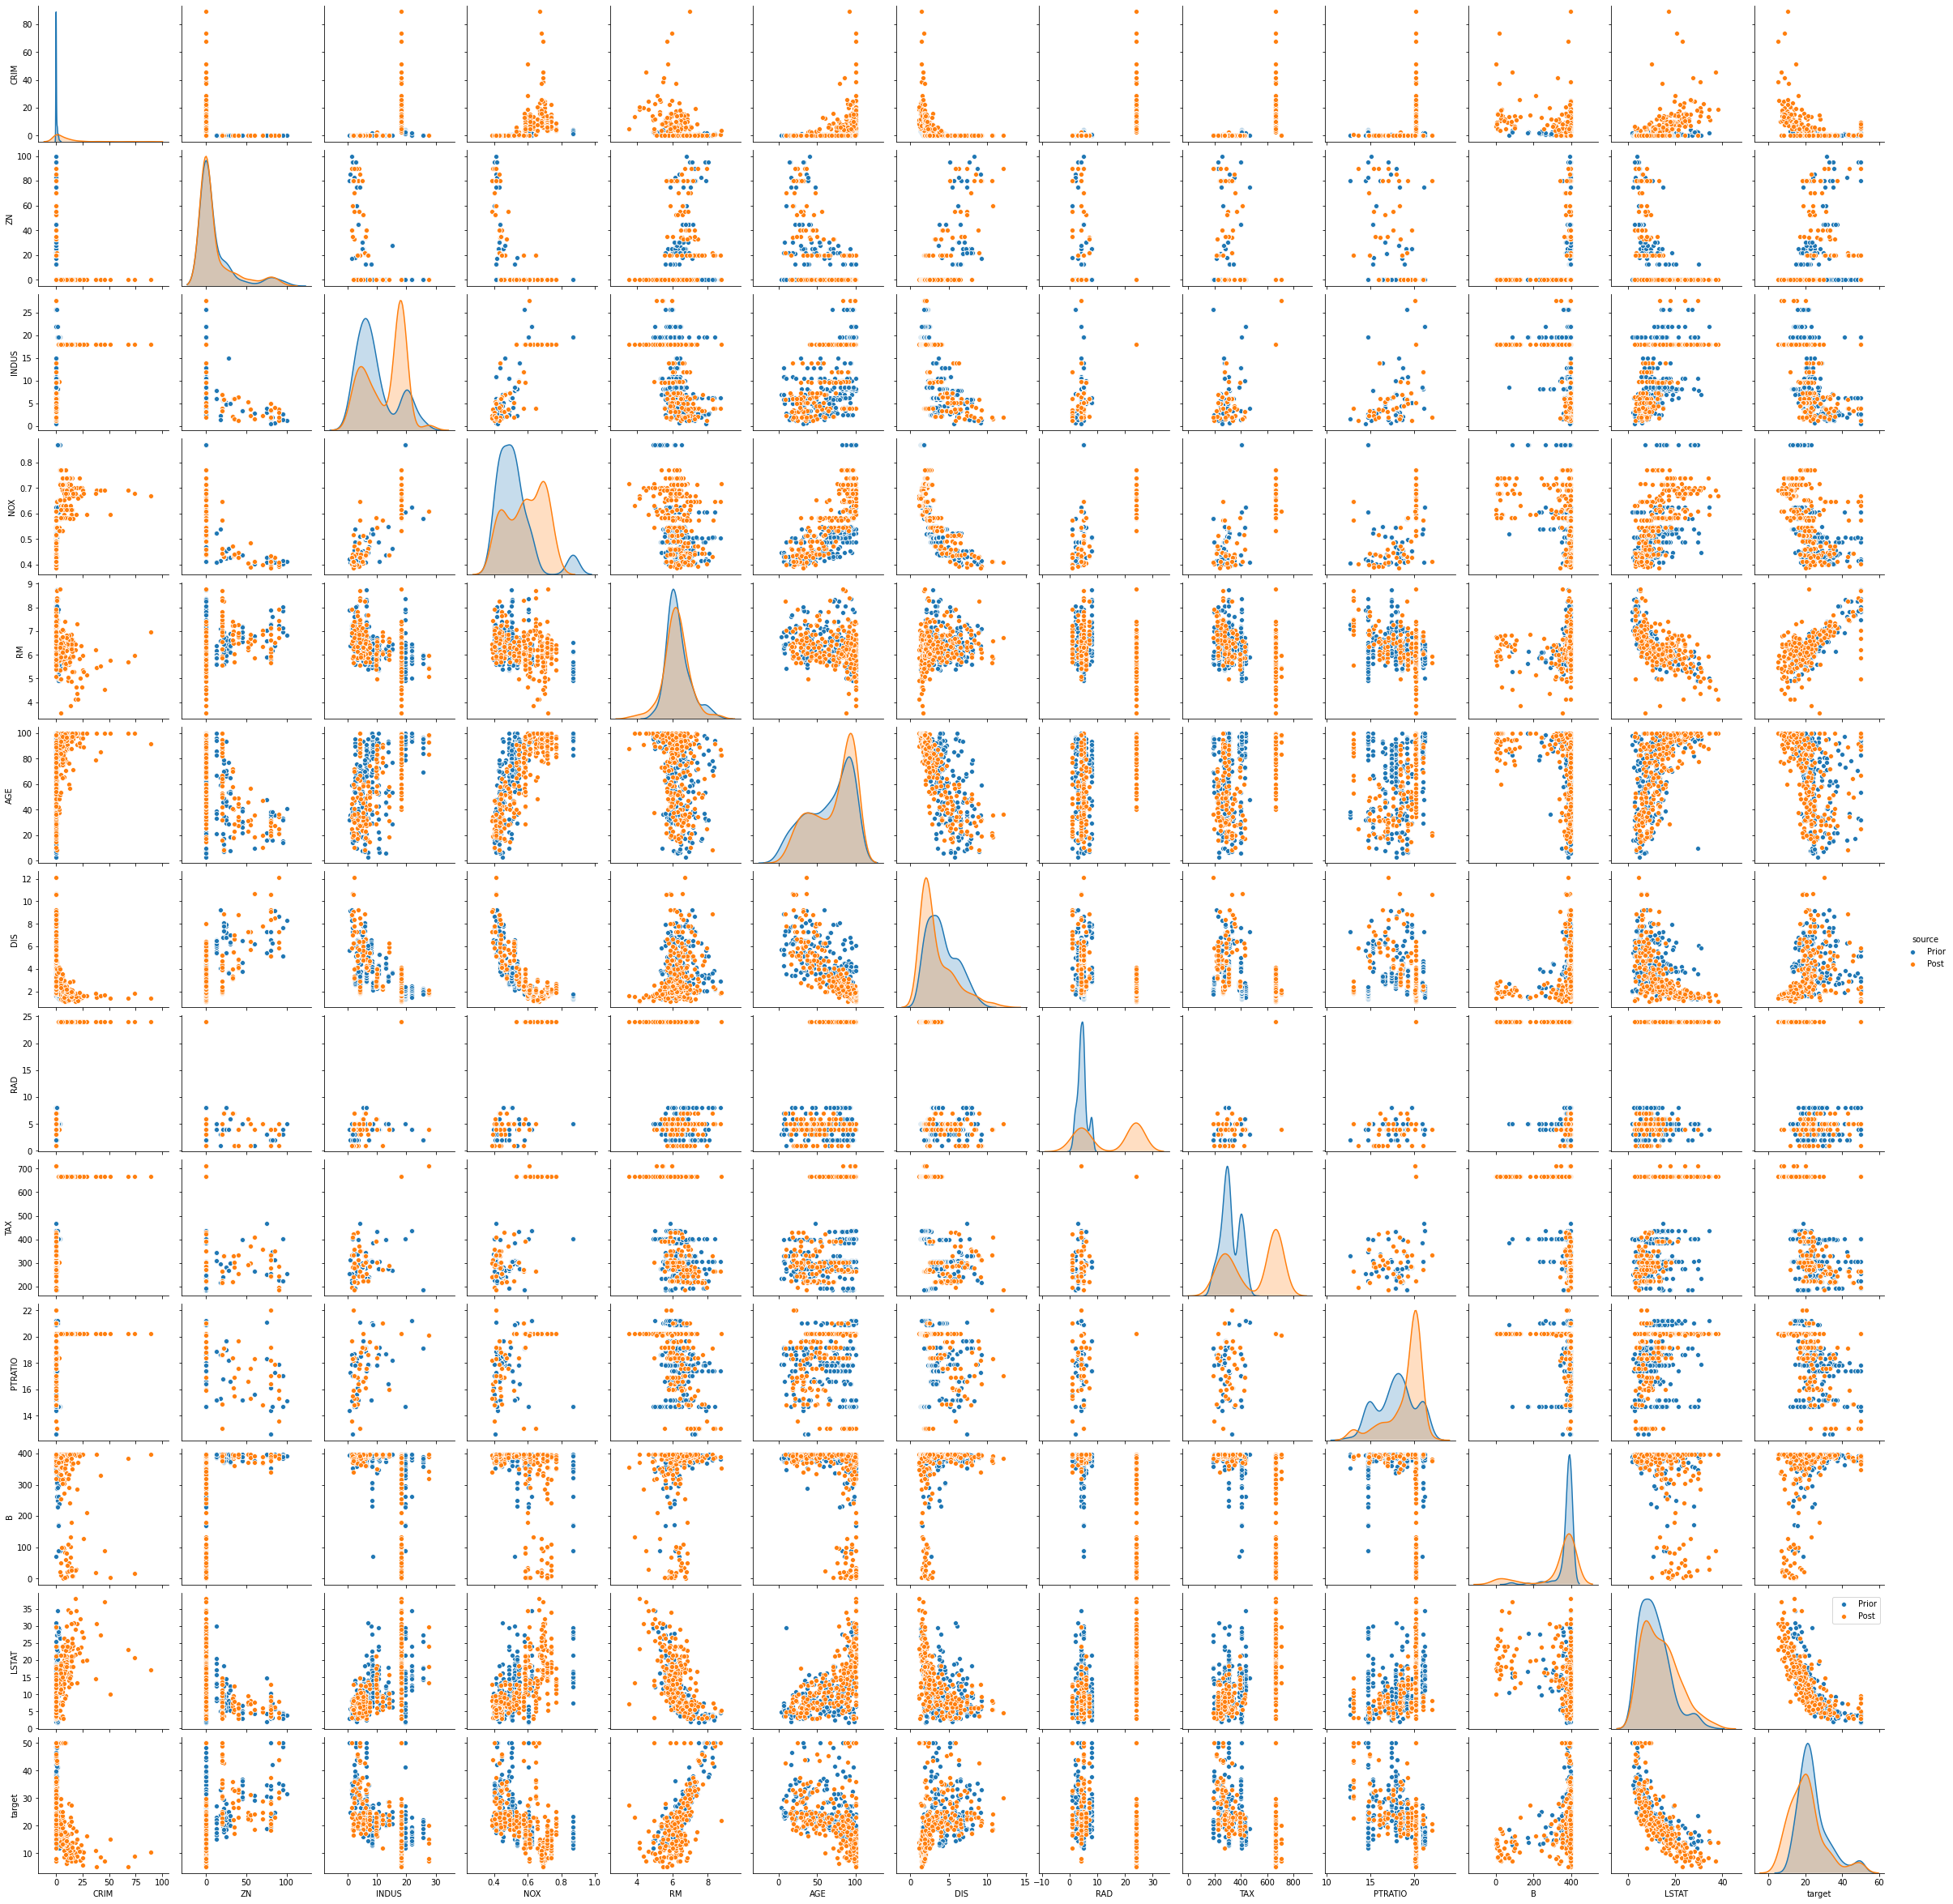

In [21]:
# plot numeric columns against each other in a pair grid
detector.plot_numeric_to_numeric()

We can see that the difference between `CRIM`, `TAX`, and `RAD` indeed look a little different.

We may also explore plots for categorical columns.

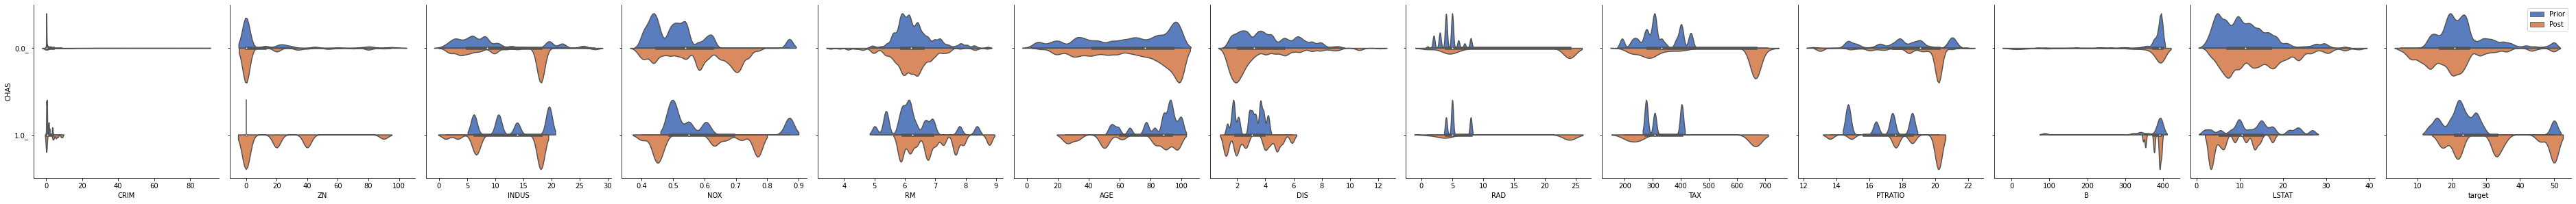

In [22]:
detector.plot_categorical_to_numeric()

Finally, you may compare the ML efficacy of the 2 datasets on a particular column

In [125]:
detector.compare_ml_efficacy(target_column='target')

,RMSE,MAE,R2
Prior,5.807271,3.736692,0.599494
Post,4.328660,2.872375,0.777479
